In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style(style='darkgrid') 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Scrubbing and initial exploration of data

In [30]:
df = pd.read_csv("kc_house_data.csv")
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [31]:
# Removing columns that aren't required for modeling
cols_to_drop = ['id']
df.drop(columns=cols_to_drop, inplace=True)

In [32]:
# checking missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 3.3+ MB


In [33]:
df['date'] = pd.to_datetime(df['date'])
df['zipcode'] = df['zipcode'].astype('category')
# for col in ['yr_built', 'yr_renovated']:
#     df[col] = pd.to_datetime(df[col]).dt.to_period('Y')


In [34]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


# Outliers, Normality Checks, Categorical Variables 

In order to keep track of which variables will be transformed, let's create a "to_normalize" list and store features in it along the way

In [35]:
to_normalize = []
categorical = []

## Dependent Variable

In [124]:
def ks_plot(data, distribution=stats.norm):
    
    std = data.std()
    loc = data.mean()
    min_ = data.min()
    max_ = data.max()
    x = np.linspace(loc-4*std, loc+4*std, len(data))
    
    y = distribution.cdf(x, loc=loc, scale=std)

    plt.figure(figsize=(10,4))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data)))
    plt.plot(x, y)
    plt.legend(['ECDF', 'CDF'])
    plt.title('Comparing CDFs for K-S test, Sample size=' + str(len(data)))
    plt.show()
    return

In [36]:
def dep_var_dist(dependent_variable ='price', df=df, logtransform=False):
    log_trans = ''
    if logtransform:
        df = df.apply(np.log)
        log_trans = 'Log Transformed '

    # dependent variable PRICE

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    f.suptitle('Distribution of '+ log_trans + dependent_variable.title() + ' Data', x=0.52, y=1, fontsize=16)

    plt.subplots_adjust(hspace=0.3)

    data = df[dependent_variable]
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title('Boxplot', fontsize=12)
    ax1.set_xlabel('')


    sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)


    ax2.set_title('Distplot', fontsize=12)
    ax2.set_xlabel(dependent_variable)
    plt.show()

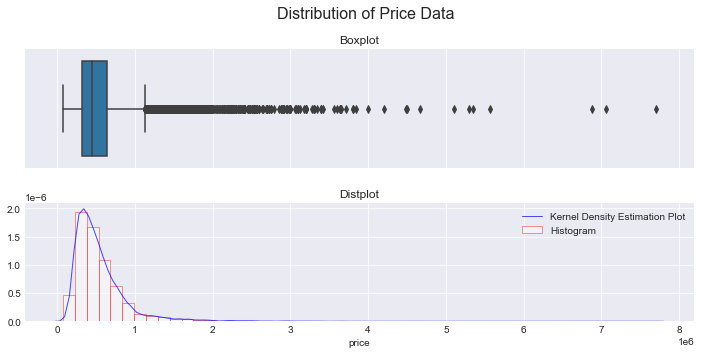

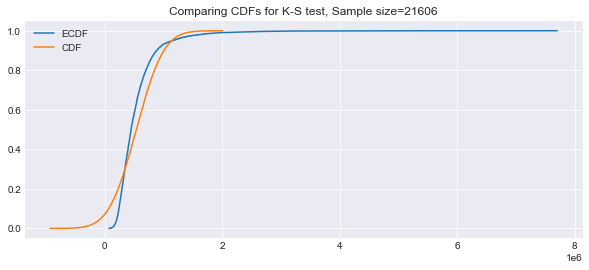

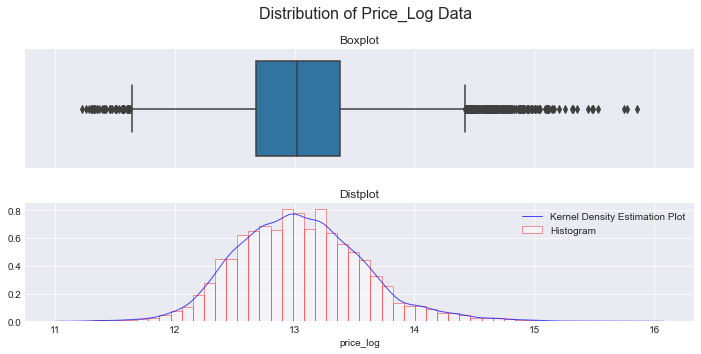

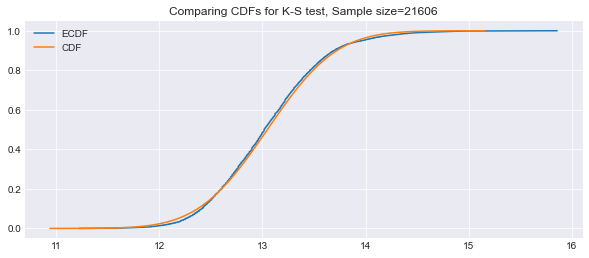

In [127]:
# plots dependent variable as is
dep_var_dist()

# plots log transformed Dep Variable
data = df[['price']]
ks_plot(df['price'])
d_stat, p_value =  stats.kstest(data, 'norm')


data['price_log'] = data['price'].apply(np.log)
dep_var_dist(dependent_variable='price_log', df=data)
ks_plot(data['price_log'])
d_stat, p_value =  stats.kstest(data['price_log'], 'norm')


The variable 'price' is somewhat normal, even though it is strongly skewed by outliers. The distribution becomes less skewed if we look at log transformed price

## Independent Variables

In [38]:
to_logtransform = []
categorical = []
X_cols = []

In [39]:
def check_distribution(cols, df=df):
    
    
    for col in cols:
        fig, axes = plt.subplots(2, 
                                 sharex='col',  gridspec_kw={"height_ratios": (.15, .85)}, 
                                 figsize = (15,5))
        fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
        
        # top  plot
        sns.boxplot(x=df[col], ax = axes[0],color = 'red')
        axes[0].set_title('Boxplot', fontsize=12)
        axes[0].set_xlabel('')
        
        # middle plot
        sns.distplot(df[col], hist=True, 
                     hist_kws={"linewidth": 1, "edgecolor" :'red', "alpha": 0.4,
                               "color":  "w", "label": "Histogram"},
                     kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                          "alpha": 0.7, 'label':'Kernel Density Estimation Plot'},
                     fit= stats.norm, 
                     fit_kws = {'color' : 'green', 'label' : 'parametric fit',
                                "alpha": 0.7, 'linewidth':3},
                 ax=axes[1])
        axes[1].set_title('Density Estimations', fontsize=12)
        axes[1].set_ylabel('frequency/probability')
        axes[1].set_xlabel(col)
        axes[1].legend()
        plt.show()
        
def boxplots_category(col, df=df):
    f, axes = plt.subplots(1, 2, figsize=(15,8), 
                           sharey = True, 
                           gridspec_kw={"width_ratios": (.1, .9)})
    f.tight_layout()
    data = df[[ col, 'price']]
    a = sns.boxplot(x=data['price'].apply(np.log), orient='v', ax=axes[0])
    b = sns.boxplot(x=df[col], y=data['price'].apply(np.log), ax=axes[1])
    b.set_title("Price_log Distribution by "+col,fontsize=20)
    b.set_xlabel(col,fontsize=15)
    b.set_ylabel("",)
    b.tick_params(labelsize=9)
    plt.xticks(rotation=70)
    plt.show()
    

### sqft_living

it is .....

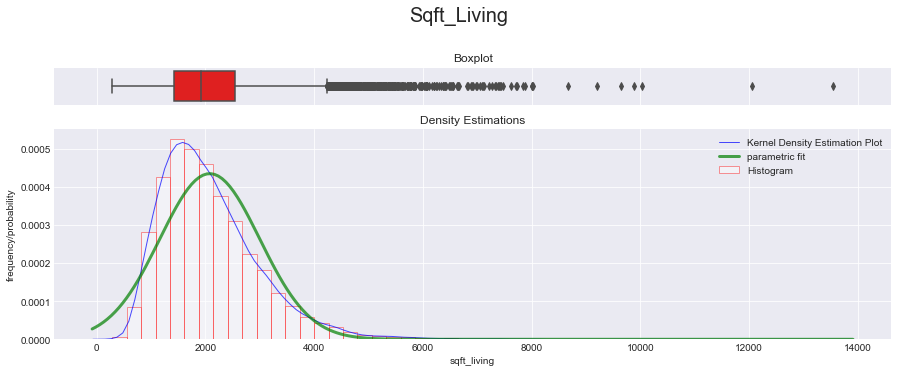

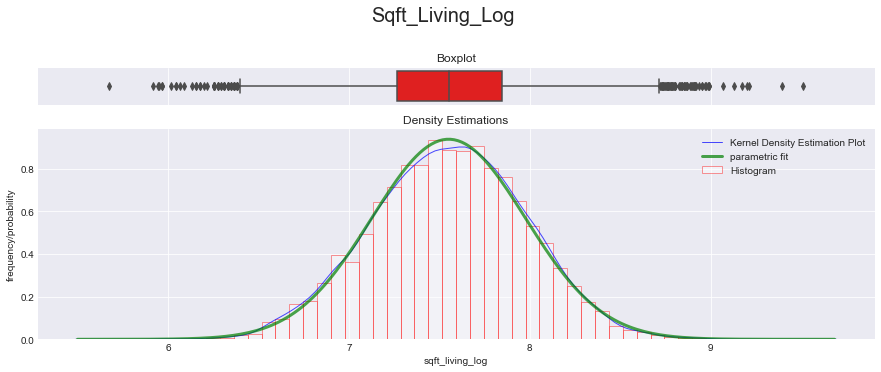

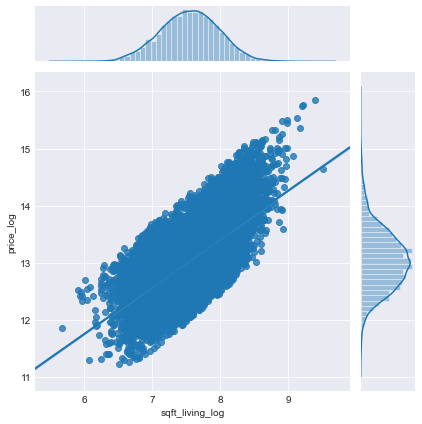

In [40]:
# distributions as is
check_distribution(cols=['sqft_living'], df=df)

# distributions of log tranformed variable
data = df[['sqft_living', 'price']].apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_living_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_living_log', y='price_log', data=data, kind='reg')

- there is a clear linear relationship price and sqft_living
- log transformation was effective in controlling the effects of outliers and the right skew

In [41]:
for l in [to_logtransform, X_cols]:
    l.append('sqft_living')

### sqft_living15

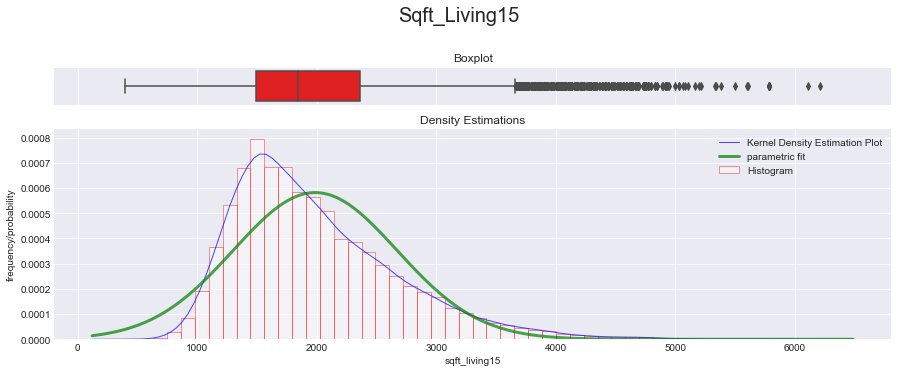

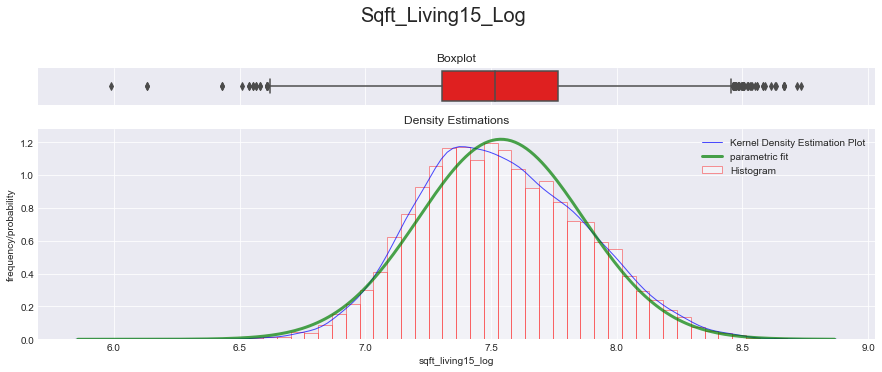

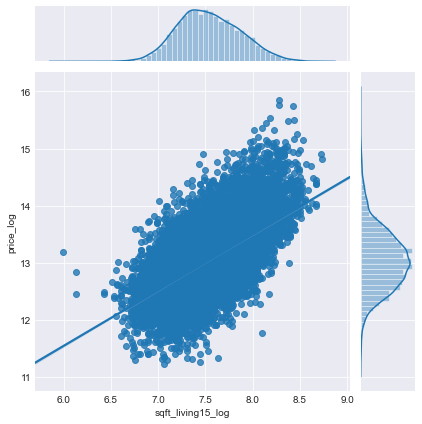

In [42]:
# distributions as is
check_distribution(cols=['sqft_living15'], df=df)

# distributions of log tranformed variable
data = df[['sqft_living15', 'price']].apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_living15_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_living15_log', y='price_log', data=data, kind='reg')

- there is a clear linear relationship price and sqft_living15
- log transformation was effective in controlling the effects of outliers and the right skew

In [43]:
for l in [to_logtransform, X_cols]:
    l.append('sqft_living15')

### sqft_above

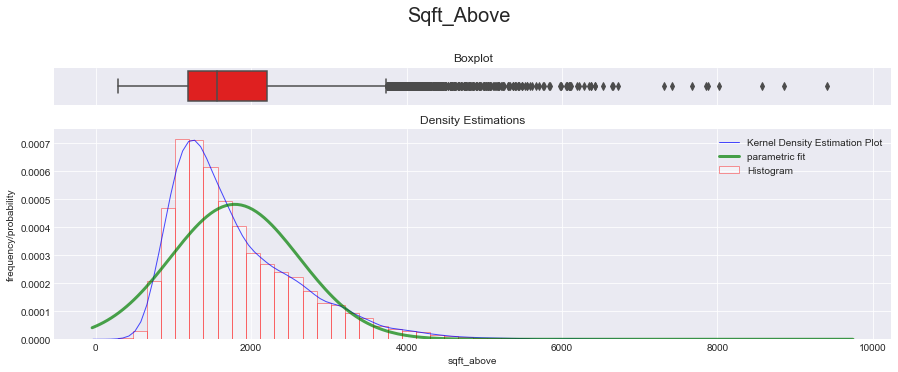

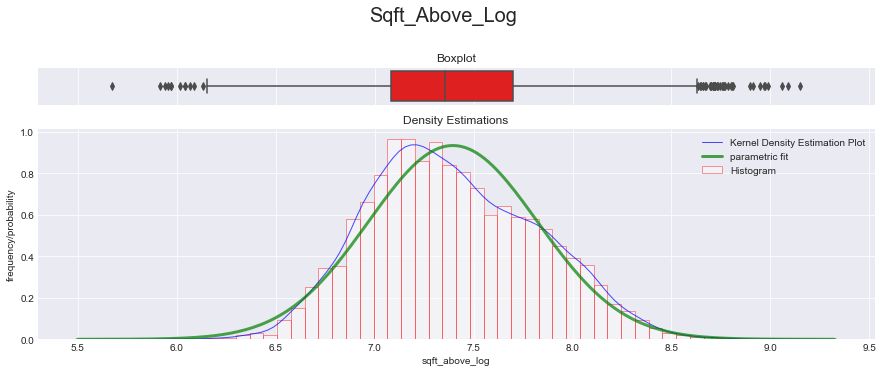

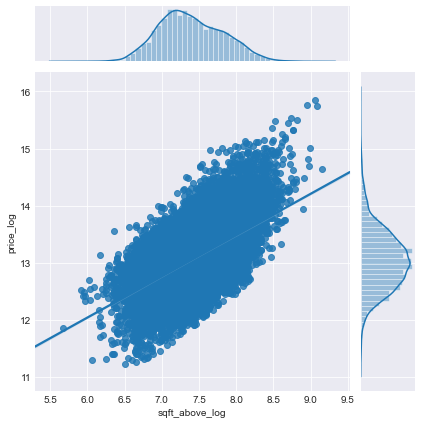

In [44]:
# distributions as is
check_distribution(cols=['sqft_above'], df=df)

# distributions of log tranformed variable
data = (df[['sqft_above', 'price']]+1).apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_above_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_above_log', y='price_log', data=data, kind='reg')

- there is a clear linear relationship price and sqft_above
- log transformation was effective in controlling the effects of outliers and the right skew

In [45]:
for l in [to_logtransform, X_cols]:
    l.append('sqft_above')

### sqft_basement

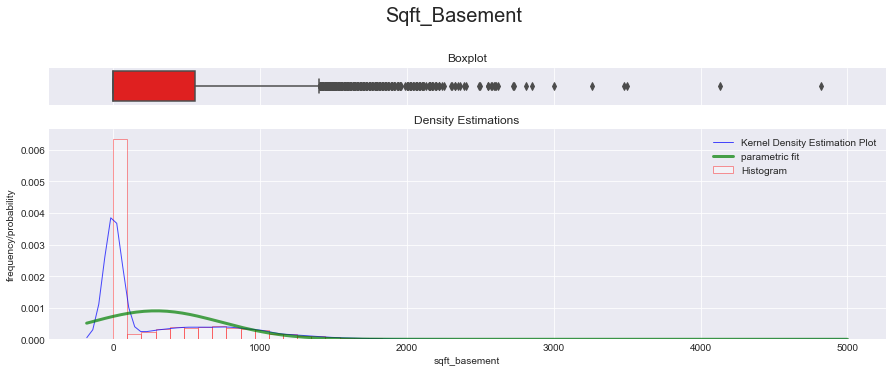

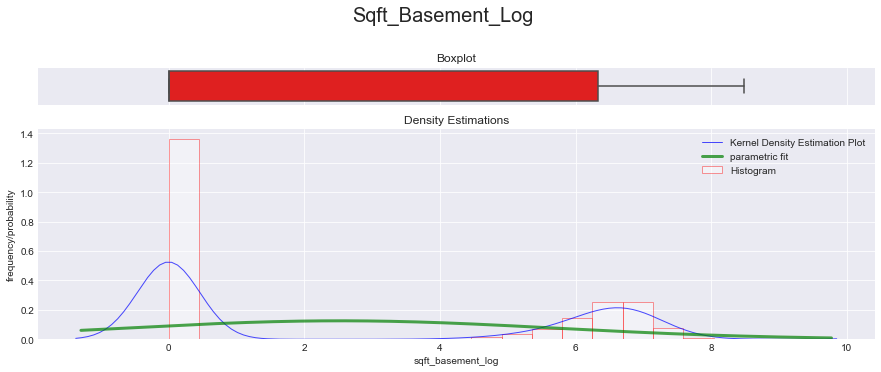

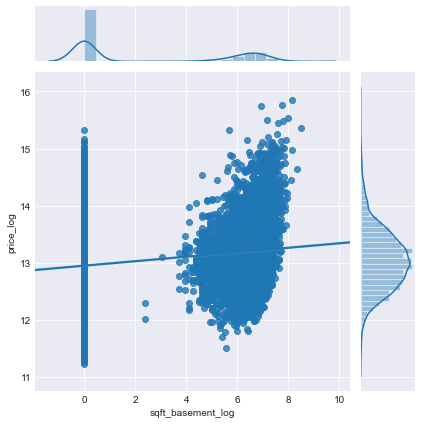

In [46]:
# distributions as is
check_distribution(cols=['sqft_basement'], df=df)

# distributions of log tranformed variable
data = (df[['sqft_basement', 'price']]+1).apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_basement_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_basement_log', y='price_log', data=data, kind='reg')

In [47]:
for l in [to_logtransform, X_cols]:
    l.append('sqft_living15')

### Sqft_lot

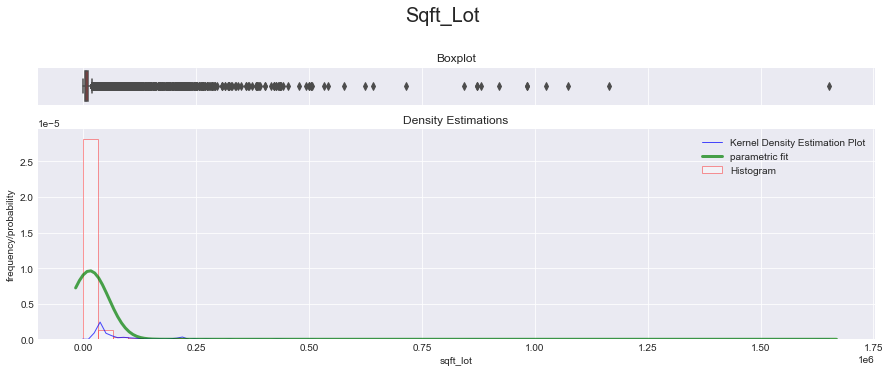

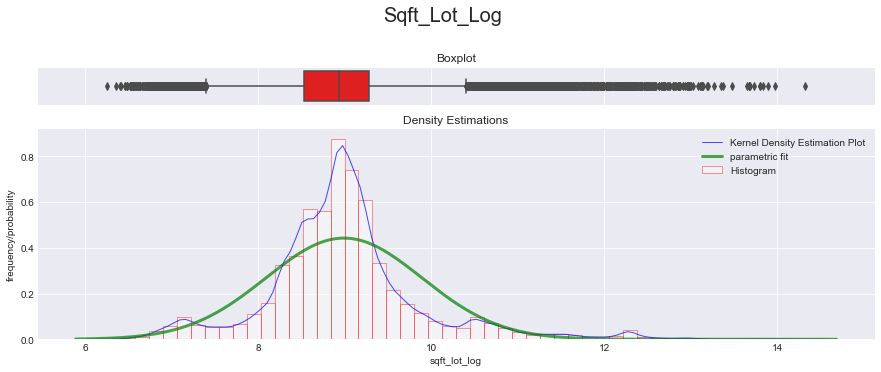

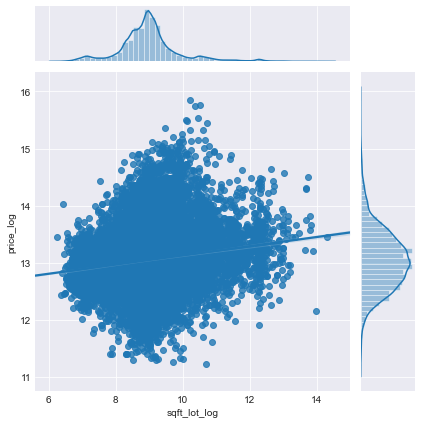

In [48]:
# distribution of lot areas - as is
data = df[['sqft_lot', 'price']]
check_distribution(cols=['sqft_lot'], df=data)

# distribution of lot areas - log transformed 
data = (data+1).apply(np.log)
data.columns = [col+'_log' for col in data.columns]

check_distribution(cols=['sqft_lot_log'], df=data)

a = sns.jointplot(x='sqft_lot_log', y='price_log', data=data, kind='reg')

- log transformation has improved the distribution by reducing skew and making it look more normal
- linear relationship with price exists, but data show high heteroscedasticity

In [49]:
for l in [to_logtransform, X_cols]:
    l.append('sqft_lot')

### sqft_lot15

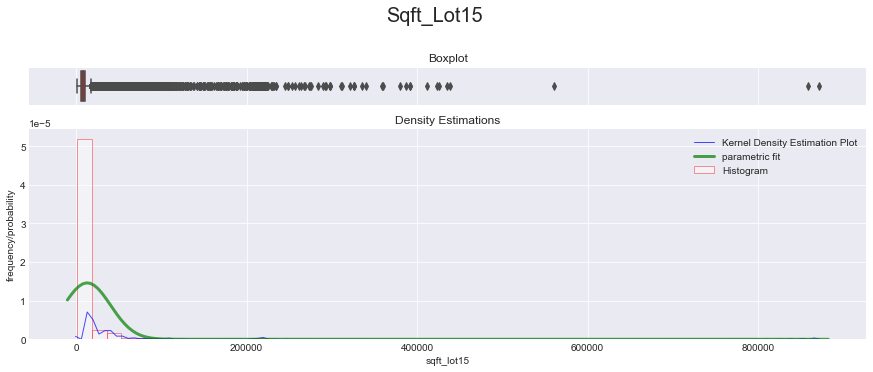

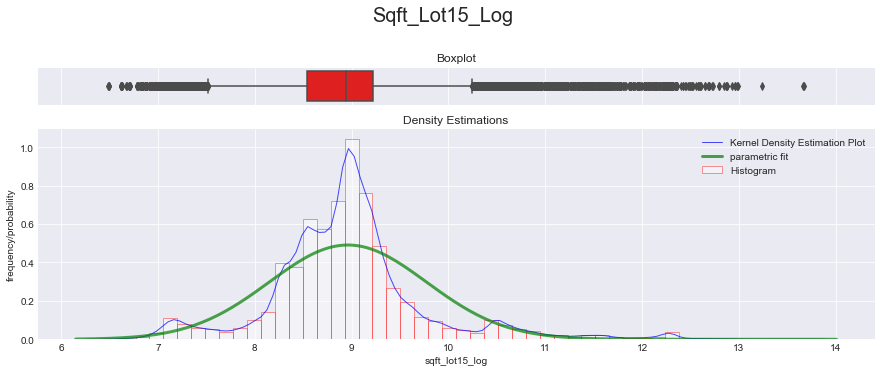

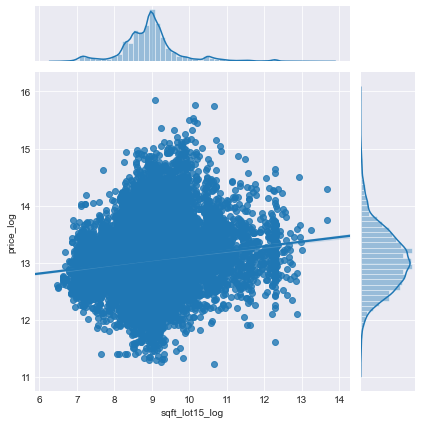

In [50]:
# distribution of lot areas - as is
data = df[['sqft_lot15', 'price']]
check_distribution(cols=['sqft_lot15'], df=data)

# distribution of lot areas - log transformed 
data = (data+1).apply(np.log)
data.columns = [col+'_log' for col in data.columns]

check_distribution(cols=['sqft_lot15_log'], df=data)

a = sns.jointplot(x='sqft_lot15_log', y='price_log', data=data, kind='reg')

- log transformation has improved the distribution by reducing skew and making it look more normal
- linear relationship with price exists, but data show high heteroscedasticity

In [51]:
for l in [to_logtransform, X_cols]:
    l.append('sqft_lot15')

### grade

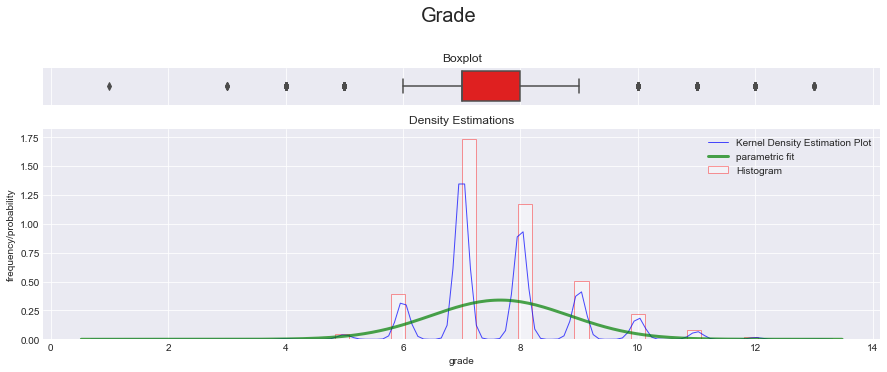

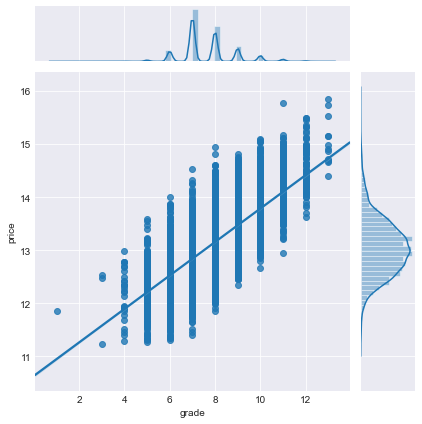

In [52]:
check_distribution(cols=['grade'], df=df)
sns.jointplot(x=df.grade, y=df.price.apply(np.log), kind='reg')

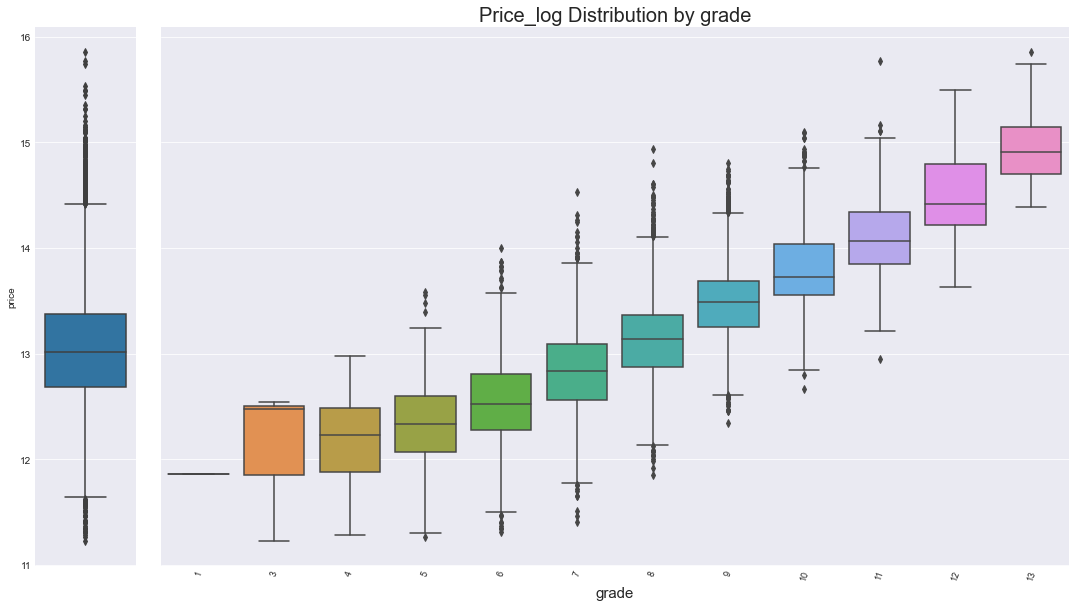

In [53]:
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()

a = sns.boxplot(x=df['price'].apply(np.log), orient='v', ax=axes[0])

b = sns.boxplot(x=df["grade"], y=df['price'].apply(np.log), ax=axes[1])
b.set_title("Price_log Distribution by grade",fontsize=20)
b.set_xlabel("grade",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- there is a linear relationship between 'grade' and the price_log
- treating 'grade' as a non-linear categorical variable will provide more flexibility in differentiating different grade levels (dummy variables)

In [54]:
for l in [X_cols]:
    l.append('sqft_lot15')

### condition

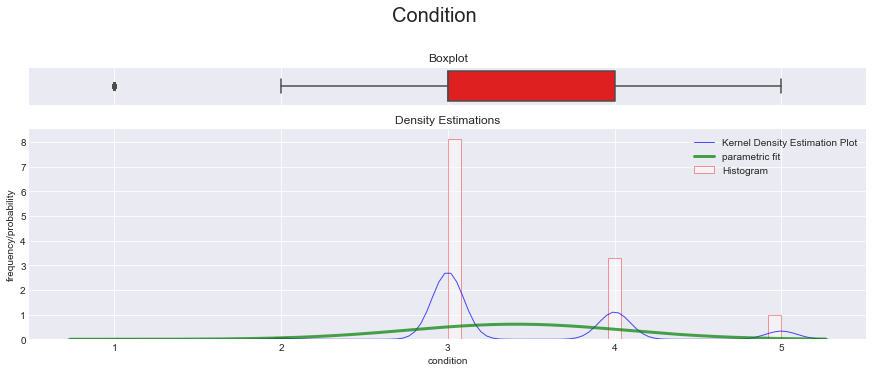

In [101]:
check_distribution(['condition'])

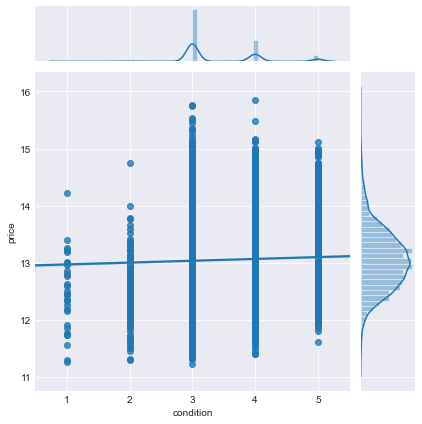

In [105]:
sns.jointplot(x=df['condition'], y=df['price'].apply(np.log), kind='reg')

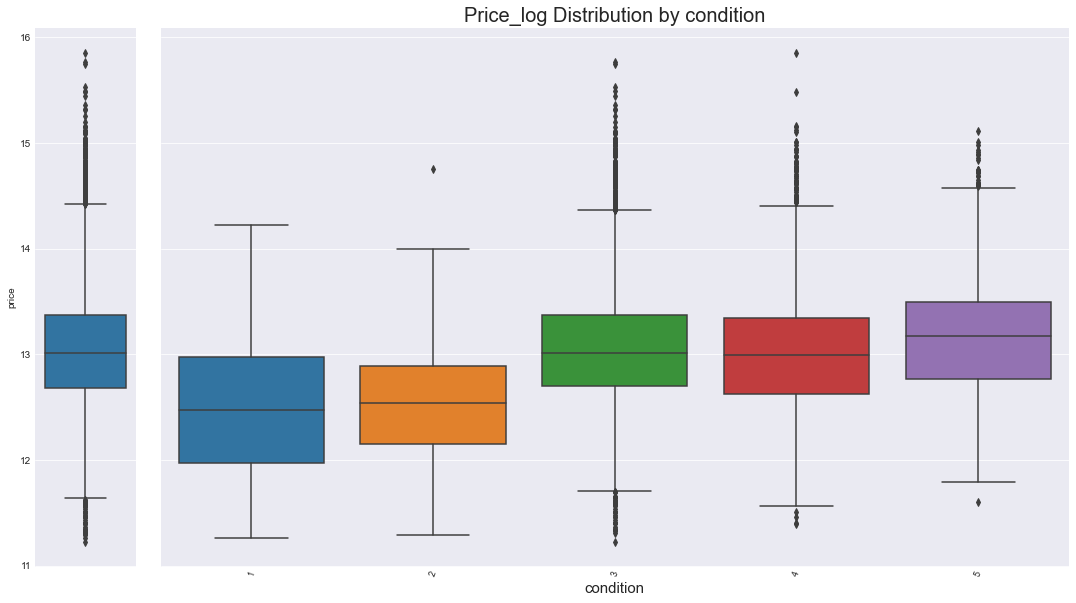

In [107]:
boxplots_category('condition')

In [108]:
for l in [X_cols, categorical]:
    l.append('condition')

### yr_built

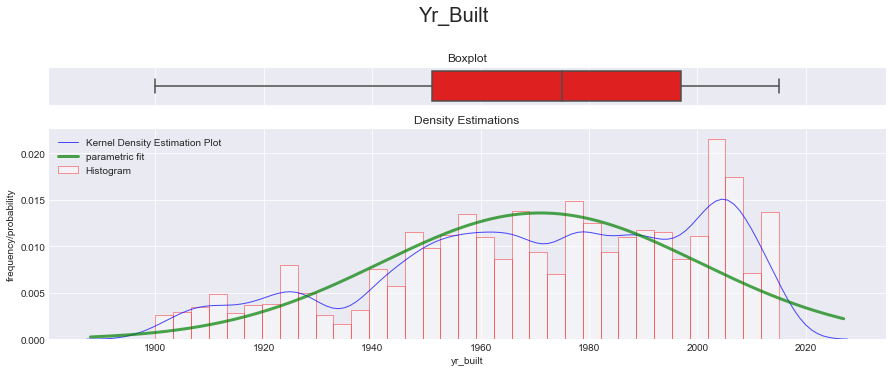

In [55]:
check_distribution(cols=['yr_built'], df=df)

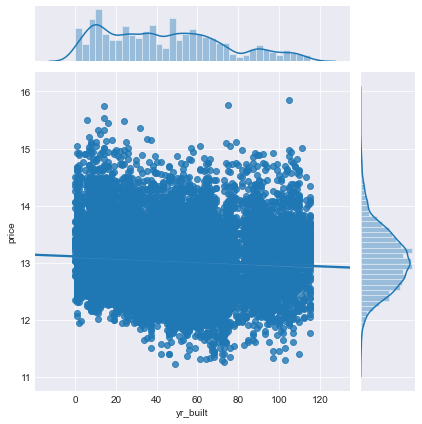

In [56]:
sns.jointplot(x=2015-df.yr_built, y=df.price.apply(np.log), kind='reg')

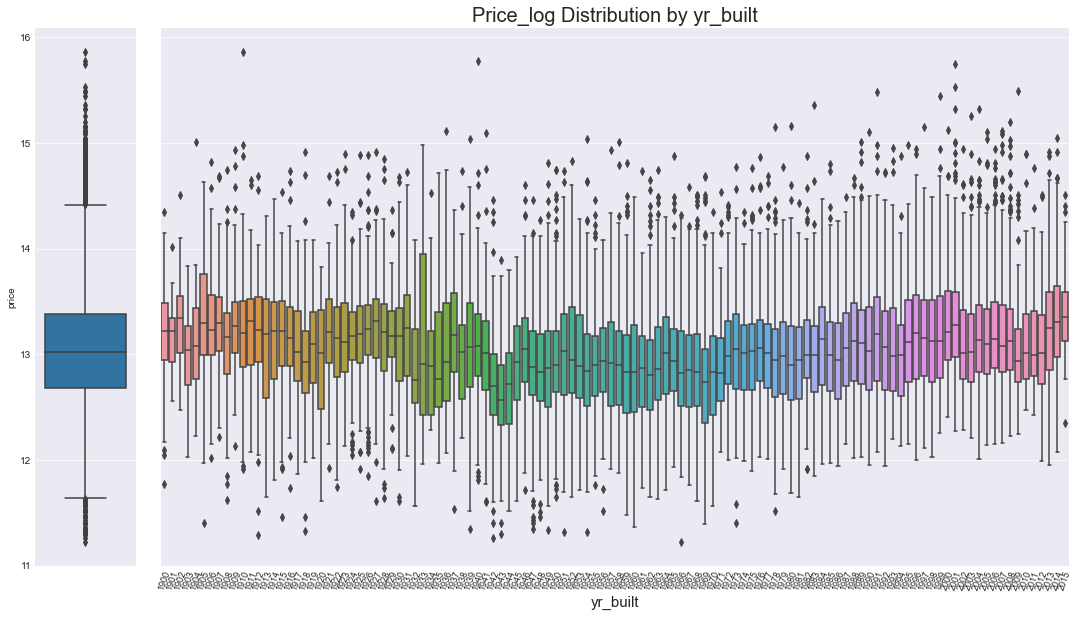

In [57]:

f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()


a = sns.boxplot(x=df['price'].apply(np.log), orient='v', ax=axes[0])

b = sns.boxplot(x=df["yr_built"], y=df['price'].apply(np.log), ax=axes[1])
b.set_title("Price_log Distribution by yr_built",fontsize=20)
b.set_xlabel("yr_built",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- there doesn't seem to be a linear correlation between yr_built and the log of the price
- this variable should be treated as a categorical variable, 

which is coherent with an assumption that specific vintage styles could be priced differently , and/or that housing development in a given year might be correlated with specific locations

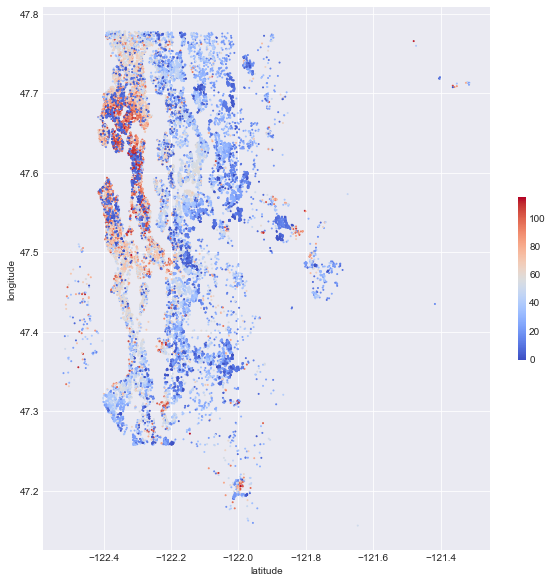

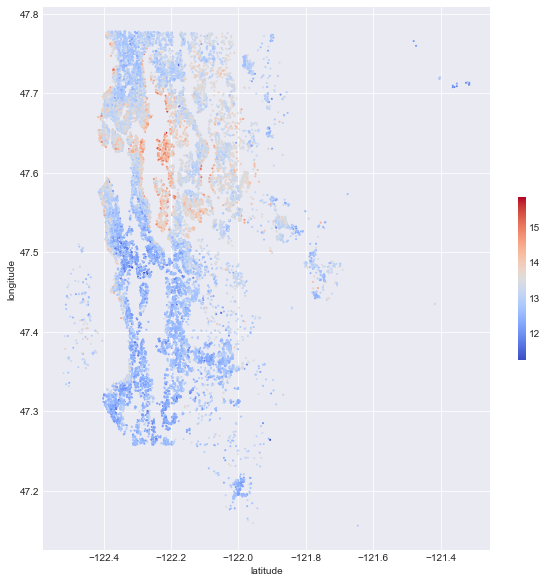

In [58]:
f = plt.figure(figsize=(10, 10))
plt.scatter(x=df['long'], y=df['lat'], 
            c=df['date'].dt.year.astype('int')-df['yr_built'], 
            s=1,
            cmap='coolwarm', 
#             alpha=0.3
           )
plt.colorbar(shrink=0.3)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()


f = plt.figure(figsize=(10, 10))
plt.scatter(x=df['long'], y=df['lat'], 
            c=df['price'].apply(np.log), 
            s=1,
            cmap='coolwarm', 
#             alpha=0.3
           )
plt.colorbar(shrink=0.3)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()





In [74]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# dummies = pd.get_dummies(df['yr_built'].astype('category'), drop_first=True)


# # dummies.columns = [str(col) for col in dummies.columns]
# digits = ['Zero', 'One', 'Two', 'Three', 'Tour', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
# col_names = []
# for col in dummies.columns:
#     name = "_".join([digits[int(digit)] for digit in (str(col))])
#     name = 'Built_In_'+name
#     col_names.append(name)

# dummies.columns = col_names

# formula_strings = ['+ C({})'.format(str(col)) for col in dummies.columns]

# data = pd.concat([df['price'].apply(np.log), dummies.astype('category')], axis=1)
# formula = 'price ~ ' + ' '.join(formula_strings)


# lm = ols(formula, data).fit()
# table = pd.DataFrame(sm.stats.anova_lm(lm, typ=2).to_dict())
# filt = table['PR(>F)']<0.05
# table[filt]

### yr_renovated

In [65]:
filt = (df['date'].dt.year.astype('int') - df['yr_renovated']) < 0
df.loc[filt, ['yr_renovated', 'date']]

,yr_renovated,date


In [68]:
df.drop(index=df[filt].index, inplace=True)

filt = (df['date'].dt.year.astype('int') - df['yr_built']) < 0
df.loc[filt, ['yr_renovated', 'date']]

,yr_renovated,date
1763,0,2014-06-25
2687,0,2014-10-29
7526,0,2014-12-31
8039,0,2014-06-24
14489,0,2014-08-26
17098,0,2014-06-17
19805,0,2014-08-01
20770,0,2014-08-28
20852,0,2014-07-09
20963,0,2014-07-31


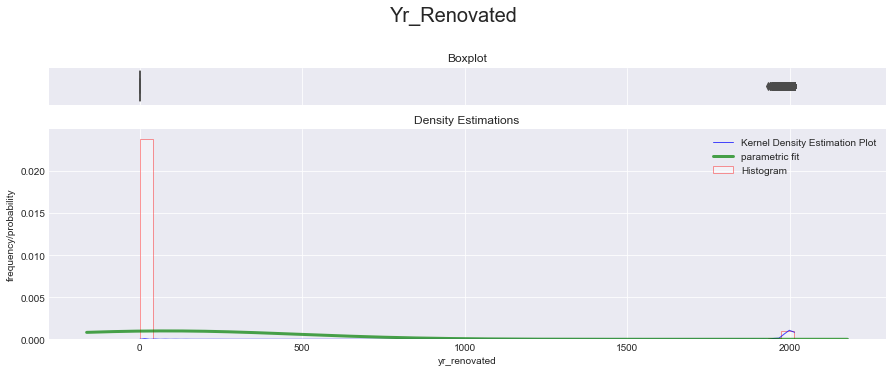

In [62]:
check_distribution(cols=['yr_renovated'])

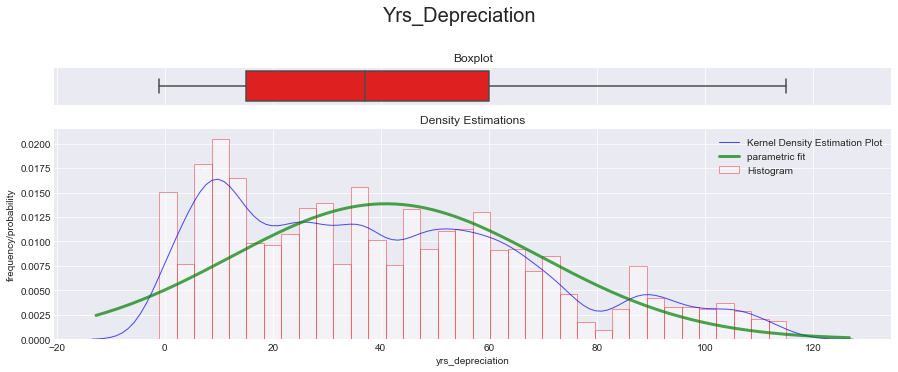

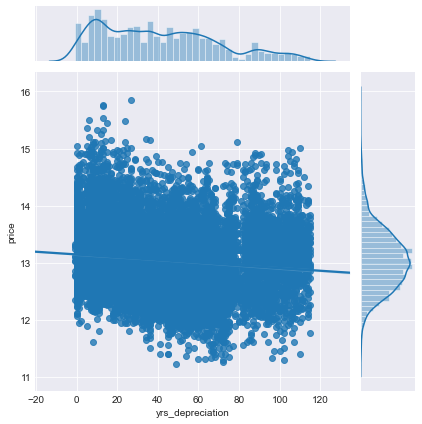

In [73]:
data = df[['yr_renovated', 'price', 'yr_built']]
data['yr'] = df['date'].dt.year.astype('int')
data['yrs_depreciation'] = [min(since_ren, since_built) for since_ren, since_built in zip(data['yr'] - data['yr_renovated'], data['yr'] - data['yr_built'])]
# data['yrs_depreciation'] = [0 if yrs < 0 else yrs for yrs in data['yrs_depreciation']]
check_distribution(cols=['yrs_depreciation'], df=data)
sns.jointplot(x=data['yrs_depreciation'], y=data['price'].apply(np.log), kind='reg')
plt.show()

In [77]:
df['yrs_depreciation'] = [
    min(since_ren, since_built) for since_ren, since_built in zip(df['date'].dt.year - df['yr_renovated'], 
                                                                  df['date'].dt.year - df['yr_built'])]
for l in [X_cols]:
    l.append('yrs_depreciation')

### Zip-codes

We shall investigate the distribution of price and price\sqft in each zip-code. It will provide us with a first impression on the relationship between outliers and zip-codes.

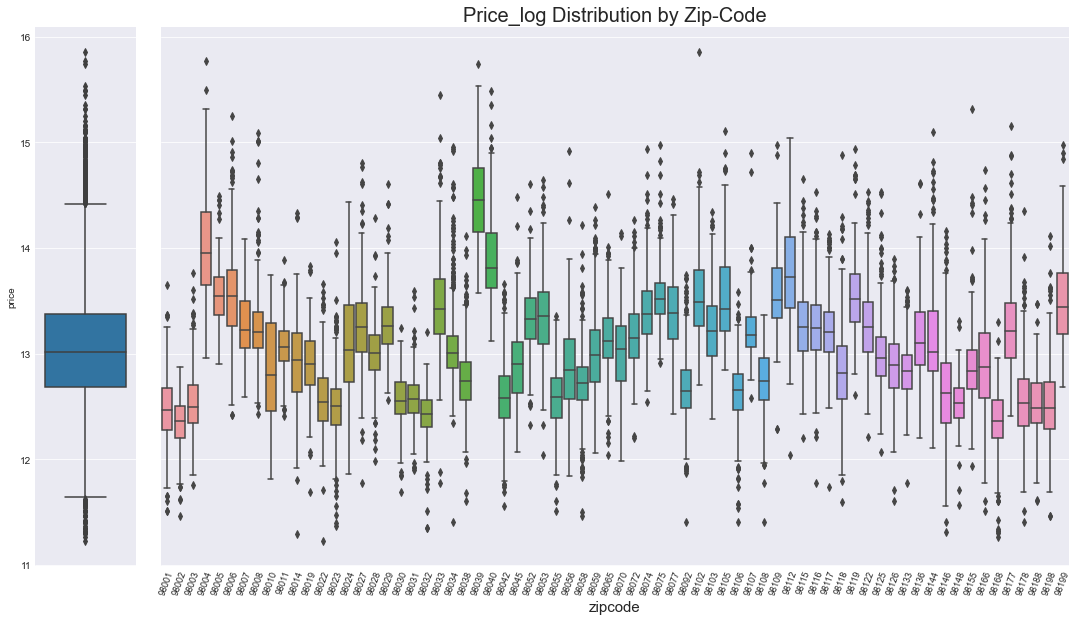

In [79]:
# zip-codes boxplots of price 
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[[ 'zipcode', 'price']]

a = sns.boxplot(x=data['price'].apply(np.log), orient='v', ax=axes[0])

b = sns.boxplot(x=df["zipcode"], y=data['price'].apply(np.log), ax=axes[1])
b.set_title("Price_log Distribution by Zip-Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- All zip-code price distributions are heavily influenced by outliers
- A few zip-code price distributions have large aintersection  with the outliers area of the overall distribution. This one  indication that outliers are not incorrect data.

In [80]:
for l in [categorical, X_cols]:
    l.append('zipcode')

### Bedrooms

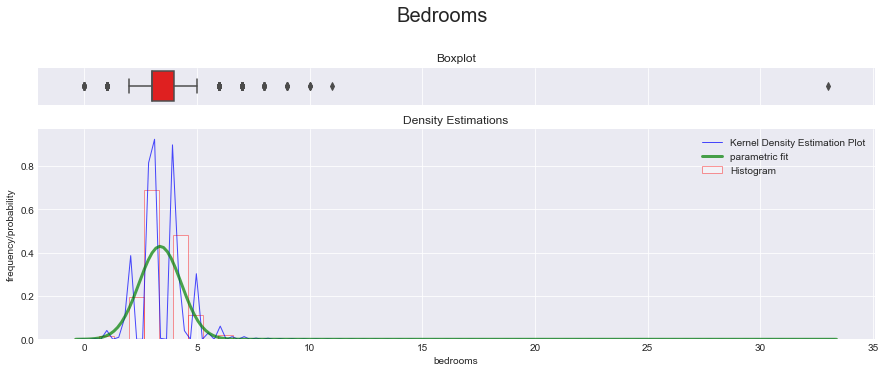

In [81]:
data = df[['bedrooms']]

check_distribution(cols=['bedrooms'], df=data)

In [82]:
filt = df['bedrooms'] > 15
print('number of bedrooms per 1000 sqft: ', (df.loc[filt, 'bedrooms'] / df.loc[filt, 'sqft_living'] * 1000).values)
df.drop(index=df[filt].index, inplace=True)

number of bedrooms per 1000 sqft:  [20.37037037]


- distribution is heavily influenced by outliers
- one outlier value refers to a property with more than 20 bedrooms per 1000 sqft, which indicates that this data point is a mistake

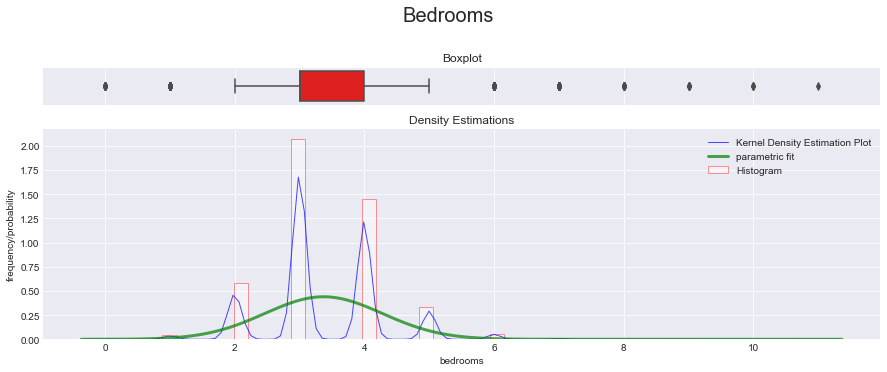

In [83]:
check_distribution(cols=['bedrooms'], df=df)

- the influence of outliers on the distribution was diminished by excluding outlier
- Distribution looks normal enough

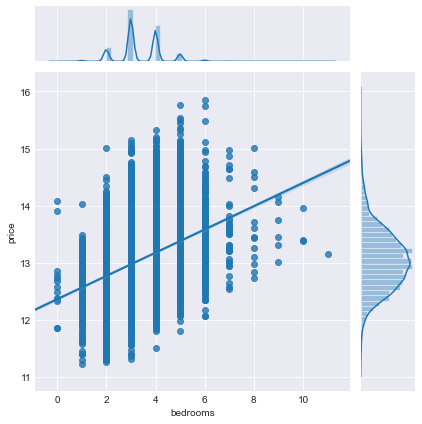

In [84]:
sns.jointplot(x=df['bedrooms'], y=df['price'].apply(np.log), kind='reg')

- positive correlation

In [88]:
for l in [X_cols]:
    l.append('bedrooms')

### Bathrooms

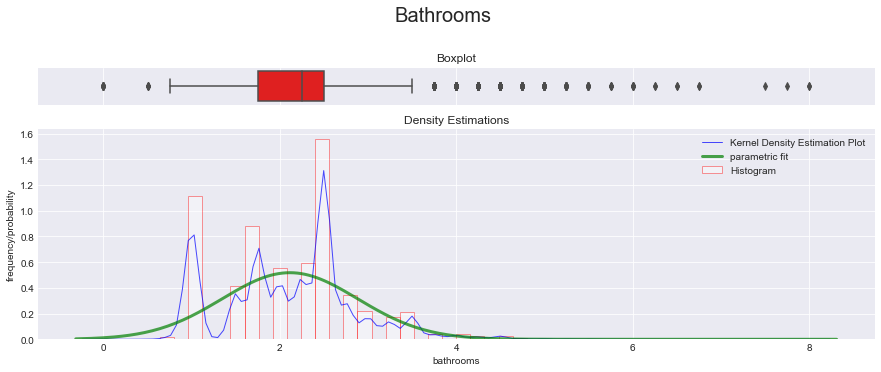

In [87]:
data = df[['bathrooms', 'sqft_living']]

check_distribution(cols=['bathrooms'], df=data)

In [89]:
filt = (df['bathrooms'] / df['sqft_living']) * 1000 > 5
df[filt]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_depreciation


- Assuming that a reasonable top threshold for bathrooms 5 per 1000 square feet, there are no incoherent outliers in the distribution.
- distribution looks somewhat normal, even though it is skewed

- the influence of outliers on the distribution was diminished by the log transformation
- Distribution looks normal enough

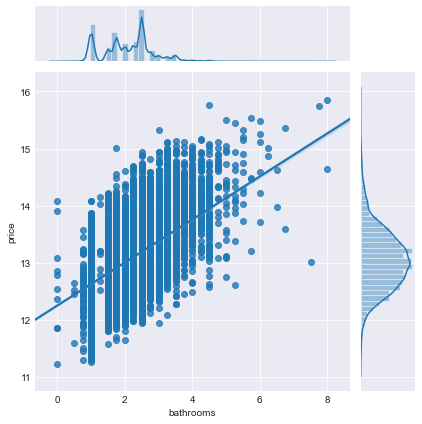

In [91]:
sns.jointplot(x=df['bathrooms'], y=df['price'].apply(np.log), kind='reg')

- positive linear correlation is observed

In [94]:
for l in [X_cols]:
    l.append('bathrooms')

### Floors

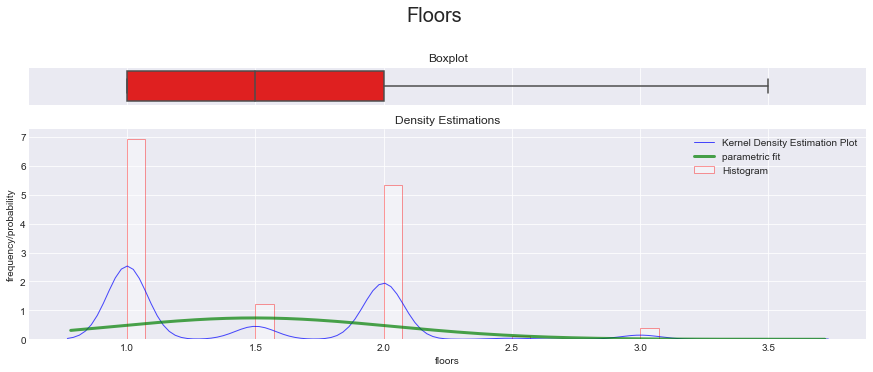

In [95]:
check_distribution(cols=['floors'], df=df)

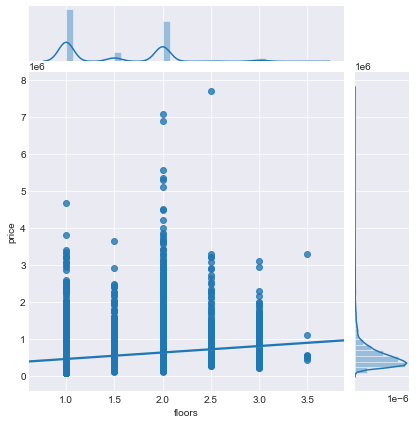

In [96]:
sns.jointplot(x='floors', y='price', data=df, kind='reg')

- no clear linear correlation
- distribution not Normal

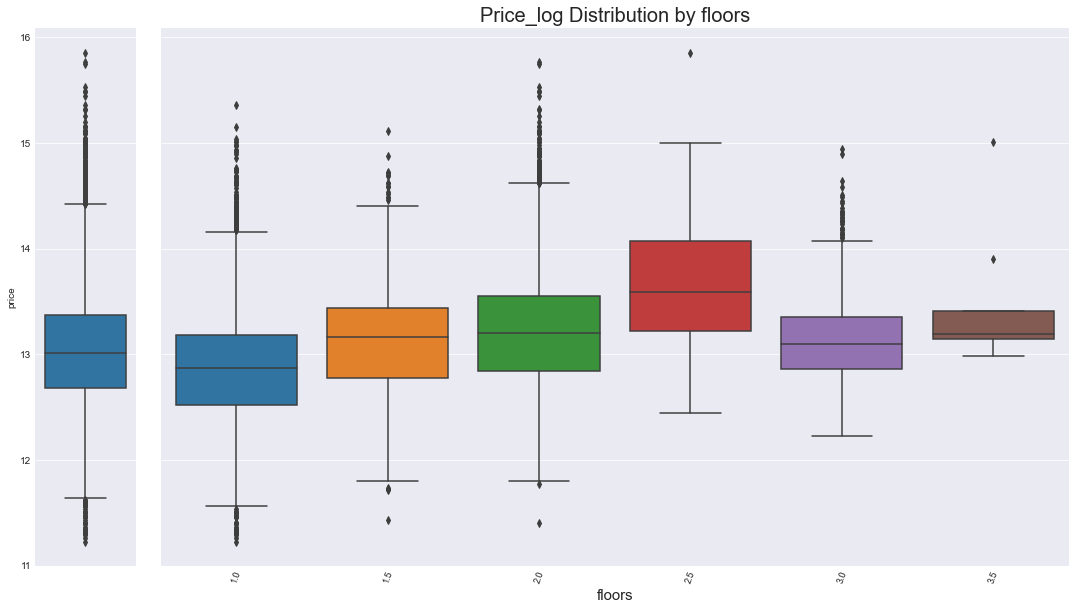

In [97]:
boxplots_category('floors')

### waterfront

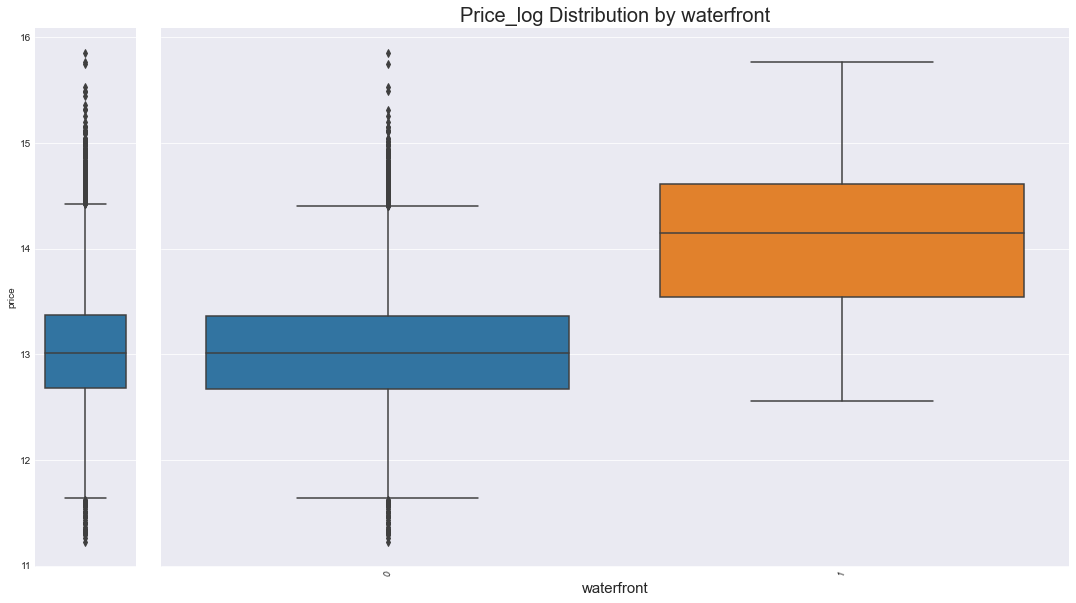

In [99]:
boxplots_category('waterfront')

In [100]:
for l in [categorical, X_cols]:
    l.append('waterfront')

### view

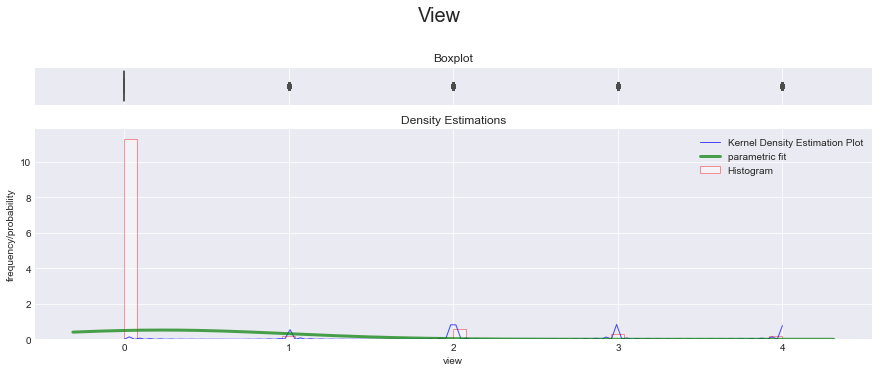

In [110]:
check_distribution(['view'])

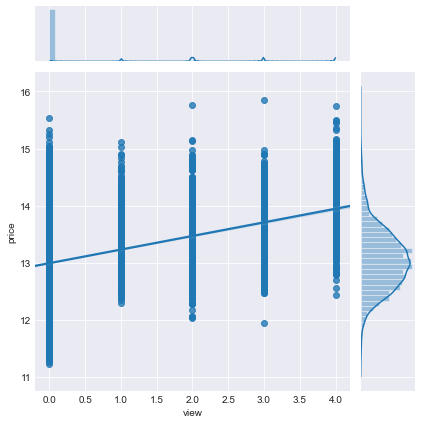

In [112]:
sns.jointplot(x=df['view'], y=df['price'].apply(np.log), kind='reg')

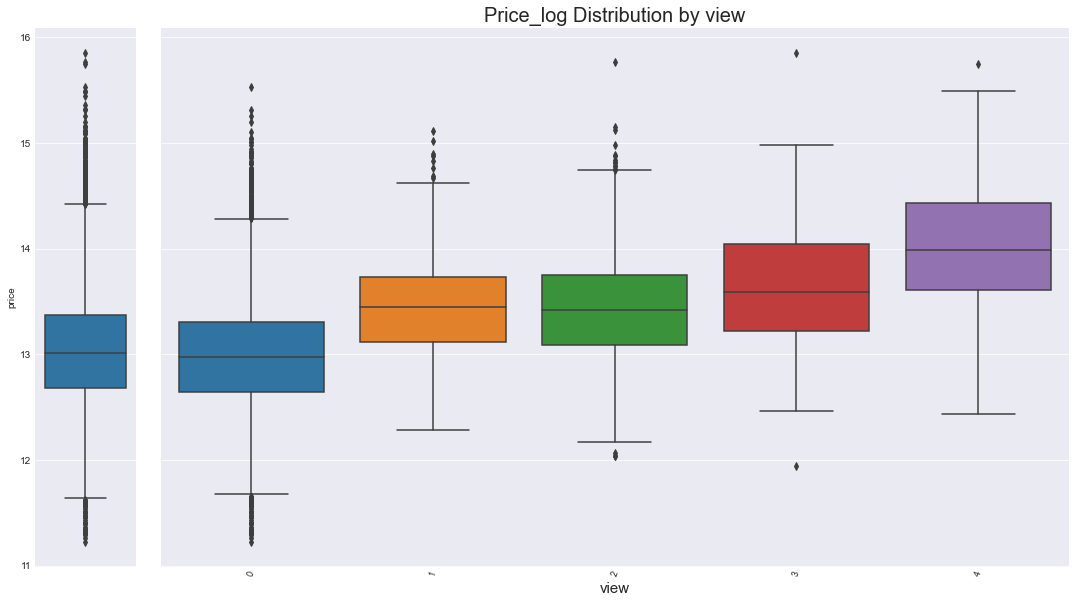

In [109]:
boxplots_category('view')

- even though a linear relationship can be established, the increment in price given an increment in the view score is not consistent throughout the all values
- treating the variables as a category will provide for more flexibility and accuracy 

In [113]:
for l in [X_cols, categorical]:
    l.append('view')

# Multicollinearity

In [129]:


def create_colinearity_df(correlation_hurdle, variables_list, df):
    """Function that finds which variables have correlation above a 
    certain threshold.
    
    ***
    Function takes in as arguments a correlation hurdle, a list of variables 
    and a Data Frame.
    
    Returns a correlation matrix as a pandas Data Frame
    ***
    Arguments:
    - correlation_hurdle : float between 0 and 1
    - variables_list: list of strings with variable names. Must be a column 
    name of the provided data frame
    - df : a DataFrame containing the data for the variables.
    
    """
    
    # creates a new df from a correlation matrix
    # multi index structure 
    correlations_df = pd.DataFrame(
        df[variables_list].corr().stack()).reset_index()
    
    # removes redundant correlations
    index_drop = correlations_df[
        correlations_df['level_0'] == correlations_df['level_1']].index
    correlations_df.drop(index=index_drop, inplace=True)

    # renames columns, resets index
    correlations_df.columns= ['x', 'y', 'corr']
    correlations_df.reset_index(inplace=True)
    correlations_df.drop(columns='index', inplace=True)
    
    # creates new column with the correlated pairs
    correlations_df['pair'] = list(zip(correlations_df['x'], correlations_df['y']))
    
    # drops columns used to create the pairs' column
    correlations_df.drop(columns=['x', 'y'], inplace=True)
    
    # sets the pairs as new index
    correlations_df.set_index('pair', inplace=True)
    
    # drops duplicates
    correlations_df.drop_duplicates(inplace=True)

    
    # returns only pairs with correlation above hurdle
    return correlations_df[abs(correlations_df['corr']) > correlation_hurdle]


In [130]:
create_colinearity_df(0.6, X_cols, df)

,corr
pair,
"(sqft_living, sqft_living15)",0.756435
"(sqft_living, sqft_above)",0.876743
"(sqft_living, bathrooms)",0.754722
"(sqft_living15, sqft_above)",0.732009
"(sqft_above, bathrooms)",0.685338
"(sqft_lot, sqft_lot15)",0.718551
